# Project 1: Infrared Spectral Energy Distributions

In [2]:
# Date created: Oct 9, 2020

In [11]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import emcee
import corner
plt.ion()
plt.rcParams.update({'font.size': 16, 'text.usetex': True})

In [2]:
# constants

h = 6.626e-34 #[J*s]
k = 1.381e-23 #[J/K]

DATA_PATH="data\\formatted_data.json"


In [ ]:
# properly formatting and defining a function to search through the data

path = "data\\"

files = listdir(path + 'raw\\') # lists all the file names in the 'path' directory
num_files = len(files) # stores the number of files in the 'path' directory

floats = ["Photometry Measurement", "Frequency", "Flux Density", "Upper limit of uncertainty", 'Lower limit of uncertainty']
ints = ["No."]
def return_csv(file):
    csv_dict = {}
    with open(file) as csv_file:
        csv_read = csv.reader(csv_file)

        i = 0
        for line in csv_read:
            if i == 0:
                # Initialize csv dictionary with header values as keys
                for key in line:
                    csv_dict[key] = []
                i += 1
                continue
            
            # Add the value in the csv to the corresponding key
            index = 0
            for key in csv_dict:
                if line[index] == "":
                    line[index] = None
                if key in floats and line[index] != None:
                    line[index] = float(line[index])
                if key in ints and line[index] != None:
                    line[index] = int(line[index])

                csv_dict[key].append(line[index])
                index+=1
            i +=1

    return csv_dict


data = {}

for file in files:
    name = file.replace('_Photometry_and_SED.csv', '')
    print(name)
    data[name] = return_csv(path + 'raw\\' + file)


with open(path + 'formatted_data.json', 'w') as f:
    json.dump(data, f, indent=2)



with open(DATA_PATH) as f:
    data = json.load(f)
    
keys = data.keys()
fields = None

print("Galaxies:")
for i in keys:
    fields = data[i].keys()
    print("\t- {} ({} datapoints across {} fields)".format(i, len(data[i]['No.']), len(data[i])))
    
print("\nField List:")
print(fields)

# Returns all the data associated with a given set of number keys

def get_in_key(key, numbers):
    _ret = {"flux_density":[],"frequency":[],"uncertainty":[]}
    _not_added = []
    search = data[key]['No.']
    indices = []
    for i in numbers:
        found  = 0
        for j in range(len(search)-1,-1,-1):
            if search[j] == i and not found:
                _ret["flux_density"].append(data[key]['Flux Density'][j])
                _ret["frequency"].append(data[key]['Frequency'][j])
                _ret["uncertainty"].append(data[key]['Upper limit of uncertainty'][j])
                found = 1
        if not found:
            _not_added.append(i)

    return _ret, _not_added


In [112]:
# functions

def limit(nu, T, alpha, beta):
    return 3 + beta - ((10**nu)*h/(k*T))*np.exp(h*(10**nu)/(k*T))/(np.exp(h*(10**nu)/(k*T))-1) + alpha

def model1(freq, fit):
    L, T, alpha, beta = fit
    nu_prime = optimize.newton(limit, 13, args=(T, alpha, beta))
    L1 = ((10**L)*(10**nu_prime)**(3+beta)/(np.exp(h*(10**nu_prime)/(k*T))-1)/((10**nu_prime)**(-1*alpha)))
    predictions = []
    
    for nu in freq:
        if (nu < 10**nu_prime):
            predictions.append( 1e-26*(10**L)*(nu**(3+beta))/(np.exp(h*nu/(k*T))-1) )
        else:
            predictions.append( 1e-26*L1*(nu**(-1*alpha)) )
    return predictions

def penalty(param, freq, flux, error):
    return np.sum((model1(freq, param)-flux)**2/error**2)

def lnprob(param, freq, flux, error):
     return -0.5*penalty(param, freq, flux, error)

In [43]:
# initializing the data

# All you need to do is add which numbers you want for the data points needed to be analyzed.
# Make sure the numbers are sorted in descending order to ensure the results are sorted properly
# If there is no value in the table for a field, it will be set as 'None' and will have to be manually fixed
# If the number searched for is not in the list, will be added to the 'omitted_numbers_N' list

f_NGC0958_list, omitted_numbers_1 = get_in_key('NGC0958', [99, 98, 97, 95, 92, 87,80])
f_ARP220_list, omitted_numbers_2 = get_in_key('ARP220', [89, 13, 12, 1])
f_APM08279_5255_list, omitted_numbers_3 = get_in_key('NGC0958', [1, 12, 1003, 89])


print("NGC 0958 Data: \n\tData -> {}\n\tNumbers Not Found -> {}\n".format(f_NGC0958_list, omitted_numbers_1))
print("ARP 220 Data: \n\tData -> {}\n\tNumbers Not Found -> {}\n".format(f_ARP220_list, omitted_numbers_2))
print("APM 08279+5255 Data: \n\tData -> {}\n\tNumbers Not Found -> {}\n".format(f_APM08279_5255_list, omitted_numbers_3))


frequencies_NGC = np.array(f_NGC0958_list["frequency"])
flux_densities_NGC = np.array(f_NGC0958_list["flux_density"])
errors_NGC = np.array(f_NGC0958_list["uncertainty"])

frequencies_Arp = np.array(f_ARP220_list["frequency"])
flux_densities_Arp = np.array(f_ARP220_list["flux_density"])

frequencies_APM = np.array(f_APM08279_5255_list["frequency"])
flux_densities_APM = np.array(f_APM08279_5255_list["flux_density"])

NGC 0958 Data: 
	Data -> {'flux_density': [0.034, 0.262, 2.25, 15.0, 5.25, 0.94, 0.473], 'frequency': [240000000000.0, 353000000000.0, 666000000000.0, 3000000000000.0, 5000000000000.0, 12000000000000.0, 25000000000000.0], 'uncertainty': [0.007, 0.034, 0.428, 0.212, 0.263, 0.035, 0.0616]}
	Numbers Not Found -> []

ARP 220 Data: 
	Data -> {'flux_density': [0.0432, 0.000346, 0.000136, 7.59e-09], 'frequency': [89300000000000.0, 1480000000000000.0, 1960000000000000.0, 1.45e+18], 'uncertainty': [0.00398, 3.18e-05, 1.45e-05, None]}
	Numbers Not Found -> []

APM 08279+5255 Data: 
	Data -> {'flux_density': [0.0015, 0.0577, 0.95], 'frequency': [1960000000000000.0, 681000000000000.0, 12000000000000.0], 'uncertainty': [7e-05, None, 0.044]}
	Numbers Not Found -> [1003]



# NGC 0958

<ipython-input-179-c8d4537c0a15>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


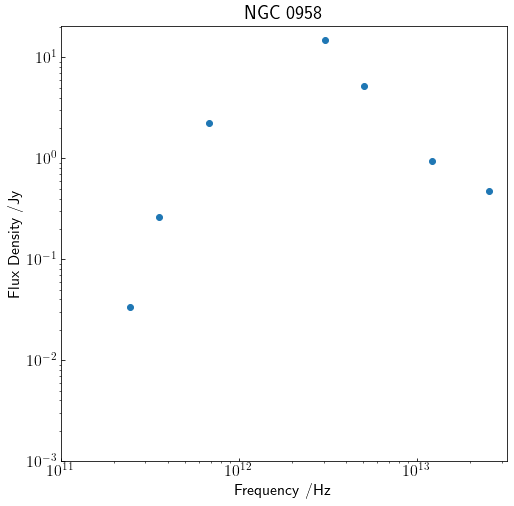

In [179]:
# hard code data, NGC 0958

frequencies_NGC = (1 + 0.019)*np.array([2.4e+11, 3.53e+11, 6.66e+11, 3e+12, 5e+12, 1.2e+13, 2.5e+13])
flux_densities_NGC = np.array([0.034, 0.262, 2.25, 14.99, 5.25, 0.94, 0.4735])
errors_NGC = np.array( [0.007, 0.034, 0.428, 0.212, 0.2625, 0.035, 0.0616] )

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_NGC, flux_densities_NGC, 'o')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('NGC 0958')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

Optimization terminated successfully.
         Current function value: 20.570935
         Iterations: 396
         Function evaluations: 678
[-41.48854068  16.58623614   1.97852595   2.80478096]


<ipython-input-180-fc79847eab0c>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


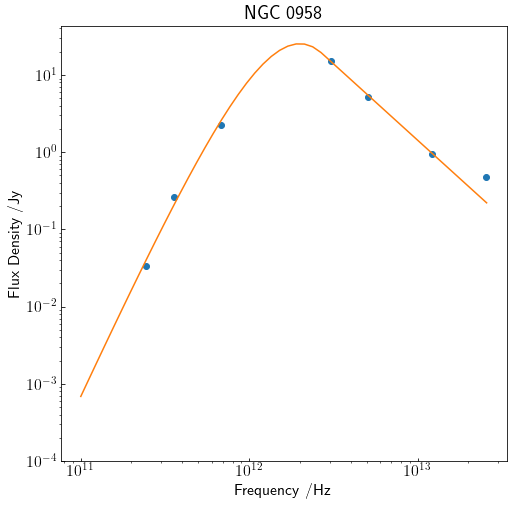

In [180]:
fit = optimize.fmin(penalty, [-32, 28.8, 2.02, 1.5], args=(frequencies_NGC, flux_densities_NGC, errors_NGC))
ngc_fit = model1(frequencies_NGC, fit)
print (fit)

#plot fit for NGC 09958
x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_NGC, flux_densities_NGC, 'o')
ax.plot(x, model1(x,fit))
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('NGC 0958')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

<ipython-input-181-d52d01e634d7>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-181-d52d01e634d7>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


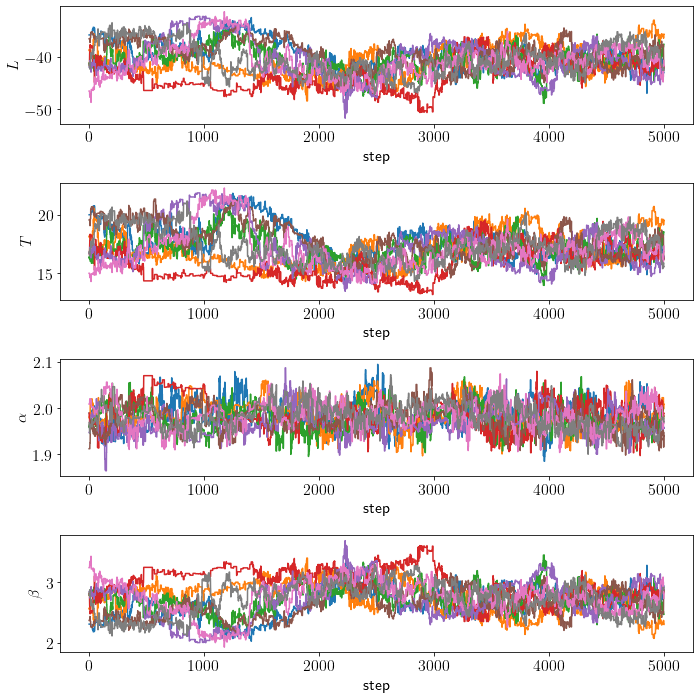

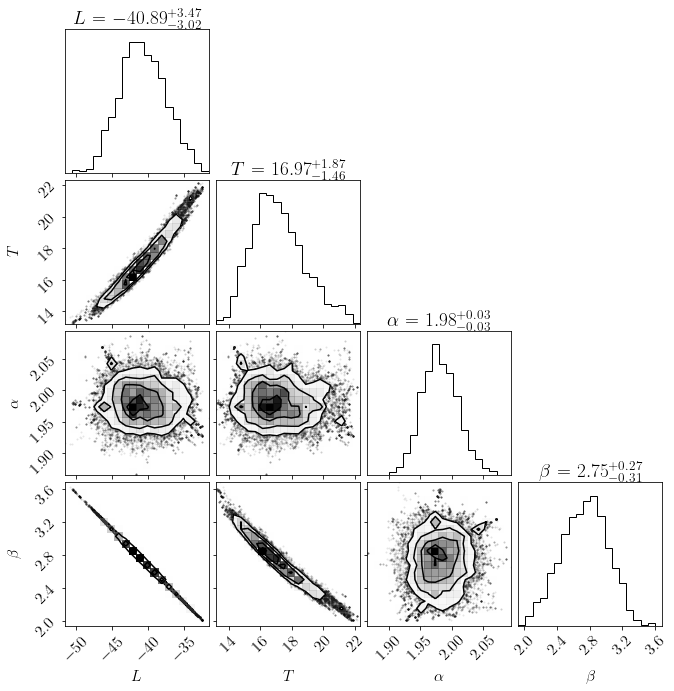

In [181]:
# Emcee run for NGC 0958 model

ndim = 4
nwalk = ndim*2
nburn = 2000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_NGC, flux_densities_NGC, errors_NGC))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()

# Arp 220

<ipython-input-182-8aaf57a934f5>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


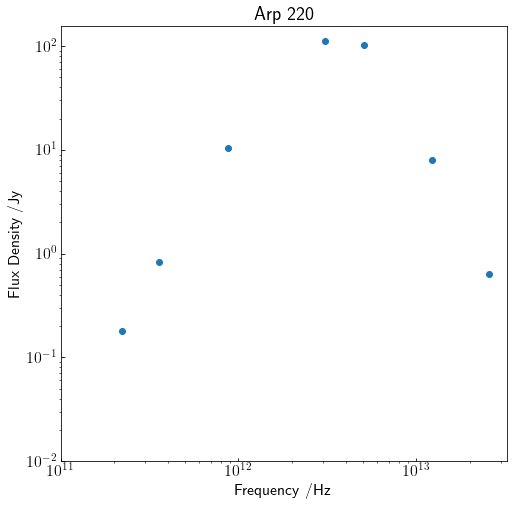

In [182]:
# Arp 220

frequencies_Arp = (1 + 0.018)*np.array( [2.17e+11, 3.53e+11, 8.57e+11, 3e+12, 5e+12, 1.2e+13, 2.5e+13] )
flux_densities_Arp = np.array( [0.178, 0.832, 10.5, 112, 103, 7.92, 0.64] )
errors_Arp = np.array( [0.032, 0.086, 3.3, 0.336, 0.144, 0.038, 0.029] )

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 1, 10, 100])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

Optimization terminated successfully.
         Current function value: 66.249131
         Iterations: 159
         Function evaluations: 285
[-29.21771852  39.54718565   3.18605137   1.71495374]


<ipython-input-183-df0730857fd6>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


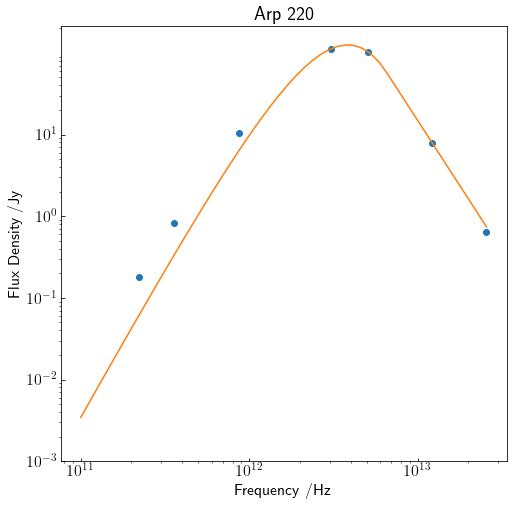

In [183]:
#fit for Arp 220
fit2 = optimize.fmin(penalty, [-31, 37.4, 2.9, 1.5], args=(frequencies_Arp, flux_densities_Arp, errors_Arp))
arp_fit = model1(frequencies_Arp, fit2)
print (fit2)

#plot fit for Arp 220
x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.plot(x, model1(x,fit2))
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

<ipython-input-184-d1bb96ee9053>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-184-d1bb96ee9053>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


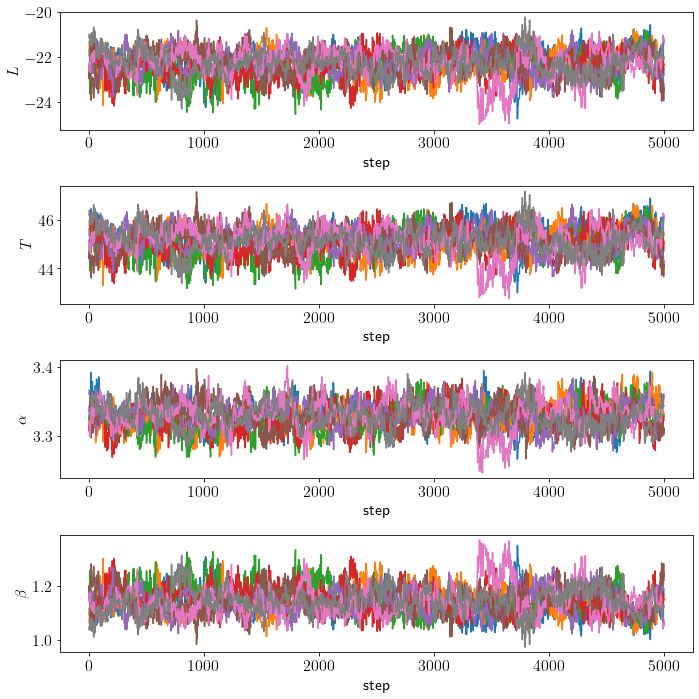

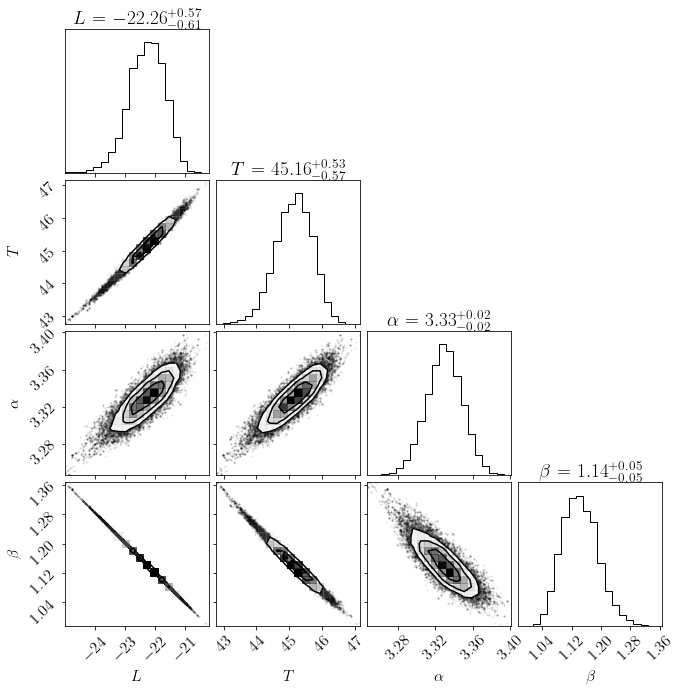

In [184]:
# Emcee run for Arp 220 model

ndim = 4
nwalk = ndim*2
nburn = 1000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit2 + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_Arp, flux_densities_Arp, errors_Arp))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()

# APM 08279+5255

<ipython-input-185-1ddd579b76cc>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


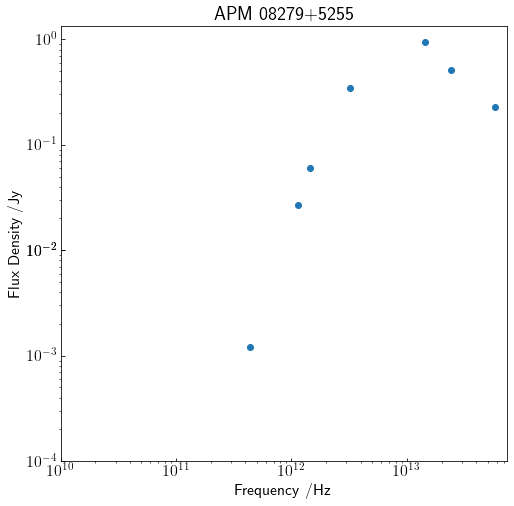

In [185]:
# APM 08279+5255

frequencies_APM = (1 + 3.8)*np.array( [9.08e+10, 2.37e+11, 3.02e+11, 6.66e+11, 3e+12, 5e+12, 1.2e+13] )
flux_densities_APM = np.array( [0.0012, 0.0266, 0.06, 0.342, 0.951, 0.511, 0.226] )
errors_APM = np.array( [0.00013, 0.0013, 0.012, 0.026, 0.22824, 0.0511, 0.03616] )

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_APM, flux_densities_APM, 'o')
ax.set_xscale('log')
ax.set_xticks([1e+10, 1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.01, 0.1, 1])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('APM 08279+5255')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

Optimization terminated successfully.
         Current function value: 5.856039
         Iterations: 235
         Function evaluations: 404
[-26.83809238  91.16741976   0.87494301   1.24262506]


<ipython-input-188-04d6842d231d>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


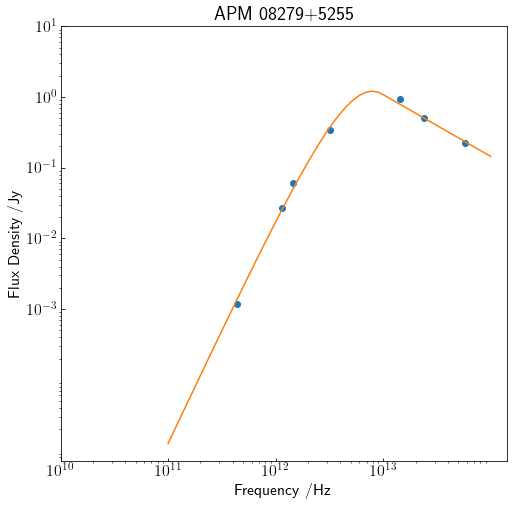

In [188]:
#fit for APM 08279+5255
fit3 = optimize.fmin(penalty, [-31, 37.4, 2.9, 1.5], args=(frequencies_APM, flux_densities_APM, errors_APM))
APM_fit = model1(frequencies_APM, fit3)
print (fit3)

#plot fit for APM 08279+5255
x = np.logspace(11,14)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_APM, flux_densities_APM, 'o')
ax.plot(x, model1(x,fit3))
ax.set_xscale('log')
ax.set_xticks([1e+10, 1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('APM 08279+5255')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

<ipython-input-189-344d0cd00ef3>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-189-344d0cd00ef3>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


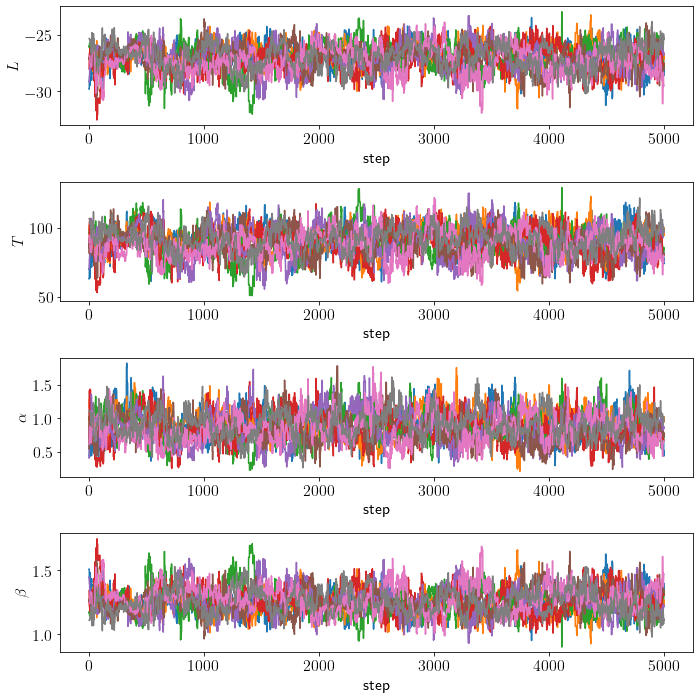

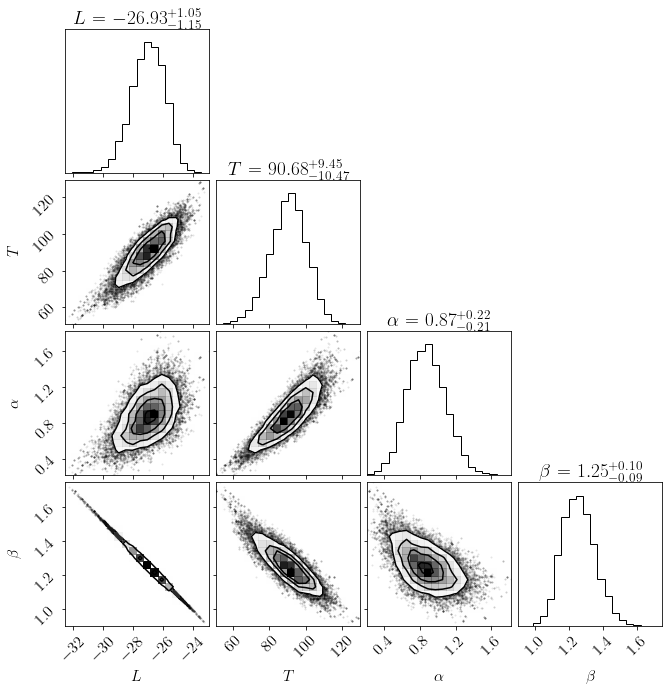

In [189]:
# Emcee run for APM 08279+5255 model

ndim = 4
nwalk = ndim*2
nburn = 1000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit3 + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_APM, flux_densities_APM, errors_APM))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()

# Subanalysis for fixed $\beta=1.5$

### NGC 0958

In [190]:
def model2(freq, fit):
    L, T, alpha = fit
    beta = 1.5
    nu_prime = optimize.newton(limit, 13, args=(T, alpha, beta))
    L1 = ((10**L)*(10**nu_prime)**(3+beta)/(np.exp(h*(10**nu_prime)/(k*T))-1)/((10**nu_prime)**(-1*alpha)))
    predictions = []
    
    for nu in freq:
        if (nu < 10**nu_prime):
            predictions.append( 1e-26*(10**L)*(nu**(3+beta))/(np.exp(h*nu/(k*T))-1) )
        else:
            predictions.append( 1e-26*L1*(nu**(-1*alpha)) )
    return predictions
    
def penalty2(param, freq, flux, error):
    return np.sum((model2(freq, param)-flux)**2/error**2)

def lnprob2(param, freq, flux, error):
     return -0.5*penalty2(param, freq, flux, error)

Optimization terminated successfully.
         Current function value: 48.202059
         Iterations: 100
         Function evaluations: 180
[-26.74887489  28.08631112   2.09518046]


<ipython-input-191-4c9fa50d16fc>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


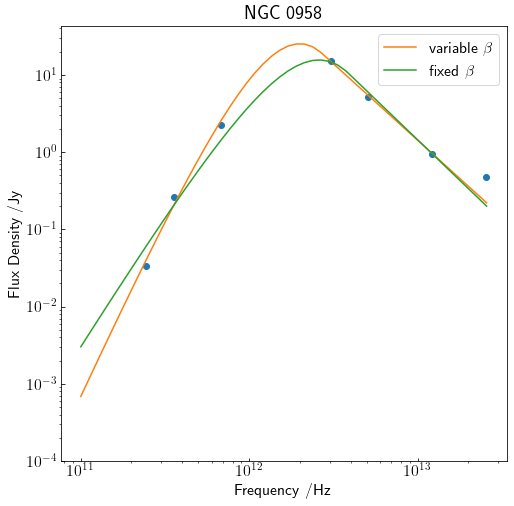

In [191]:
fit_sub = optimize.fmin(penalty2, [-32, 28.8, 2.02], args=(frequencies_NGC, flux_densities_NGC, errors_NGC))
ngc_fit_sub = model2(frequencies_NGC, fit_sub)
print(fit_sub)

#plot fit for NGC 09958
x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_NGC, flux_densities_NGC, 'o')
ax.plot(x, model1(x,fit), label=r'variable $\beta$')
ax.plot(x, model2(x,fit_sub), label=r'fixed $\beta$')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('NGC 0958')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
ax.legend()
f.show()

<ipython-input-176-56f912b94e74>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-176-56f912b94e74>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


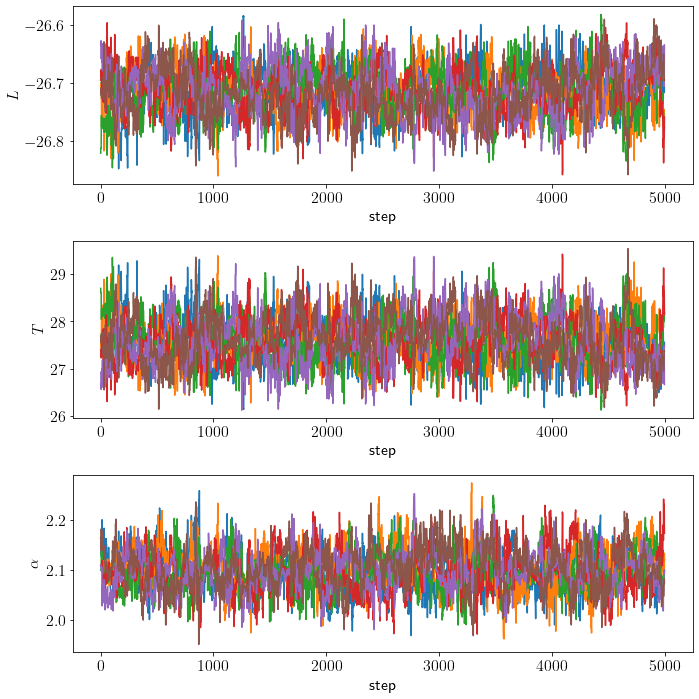

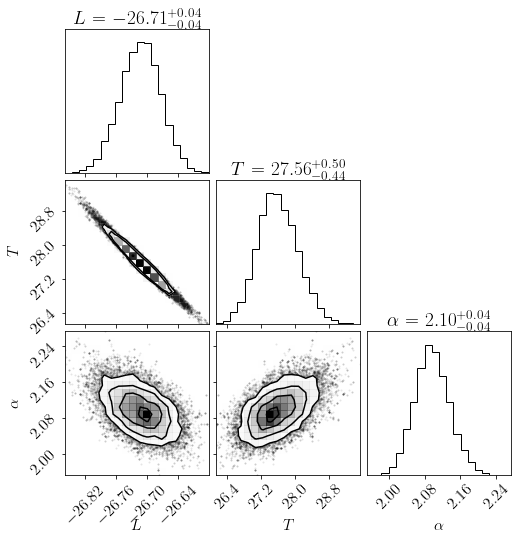

In [176]:
# Emcee run for NGC 0958 model

ndim = 3
nwalk = ndim*2
nburn = 2000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit_sub + np.random.uniform(low=-0.05, high=0.05, size=3)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob2, args=(frequencies_NGC, flux_densities_NGC, errors_NGC))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$'))
f.show()

### Arp 220

Optimization terminated successfully.
         Current function value: 36.494131
         Iterations: 145
         Function evaluations: 253
[-26.61136047  41.47725442   3.23307213]


<ipython-input-192-d3d671a4cc63>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


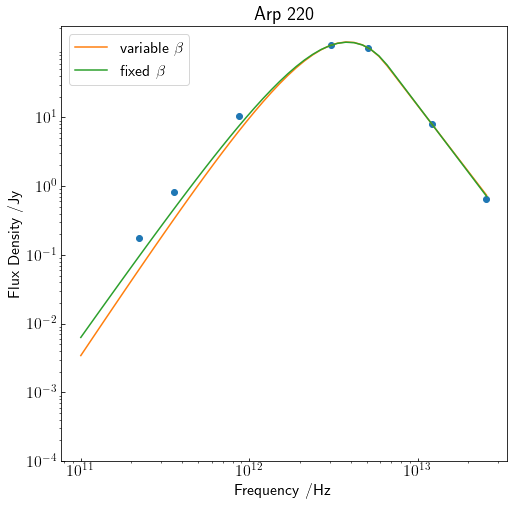

In [192]:
fit_sub2 = optimize.fmin(penalty2, [-32, 28.8, 2.02], args=(frequencies_Arp, flux_densities_Arp, errors_Arp))
arp_fit_sub = model2(frequencies_Arp, fit_sub2)
print(fit_sub2)

#plot fit for Arp 220
x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.plot(x, model1(x,fit2), label=r'variable $\beta$')
ax.plot(x, model2(x,fit_sub2), label=r'fixed $\beta$')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
ax.legend()
f.show()

<ipython-input-193-43f8d303f4d2>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-193-43f8d303f4d2>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


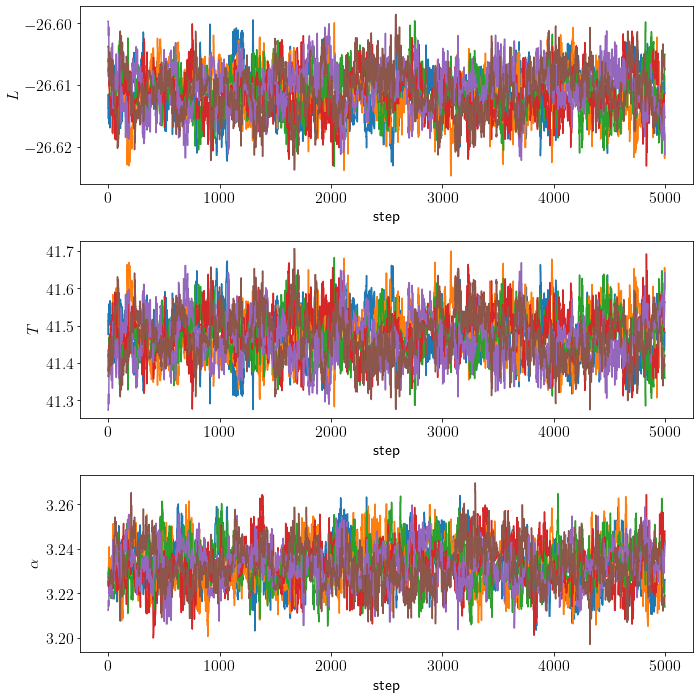

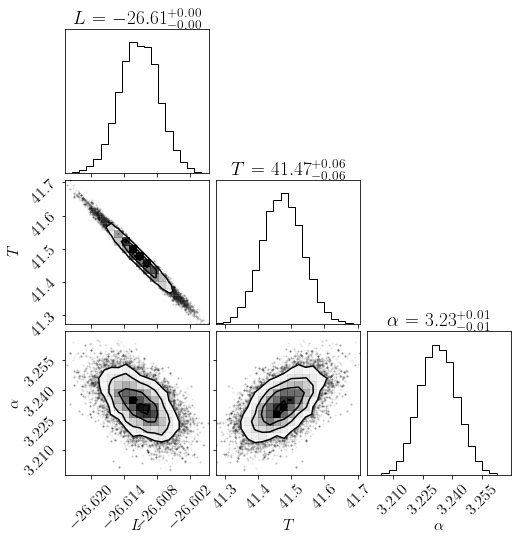

In [193]:
# Emcee run for Arp 220 model

ndim = 3
nwalk = ndim*2
nburn = 2000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit_sub2 + np.random.uniform(low=-0.05, high=0.05, size=3)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob2, args=(frequencies_Arp, flux_densities_Arp, errors_Arp))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$'))
f.show()

### APM 08279+5255

Optimization terminated successfully.
         Current function value: 11.086767
         Iterations: 155
         Function evaluations: 272
[-29.75877803  68.65791851   0.5384134 ]


<ipython-input-195-453536120d0d>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


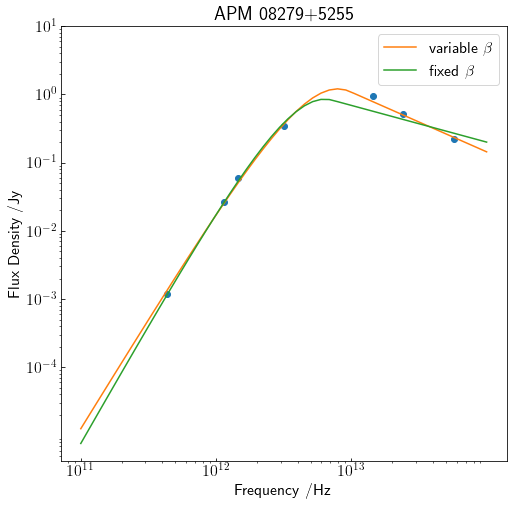

In [195]:
fit_sub3 = optimize.fmin(penalty2, [-32, 28.8, 2.02], args=(frequencies_APM, flux_densities_APM, errors_APM))
apm_fit_sub = model2(frequencies_APM, fit_sub3)
print(fit_sub3)

#plot fit for APM 08279+5255 
x = np.logspace(11,14)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_APM, flux_densities_APM, 'o')
ax.plot(x, model1(x,fit3), label=r'variable $\beta$')
ax.plot(x, model2(x,fit_sub3), label=r'fixed $\beta$')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('APM 08279+5255')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
ax.legend()
f.show()

<ipython-input-196-e02e4a717b80>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-196-e02e4a717b80>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


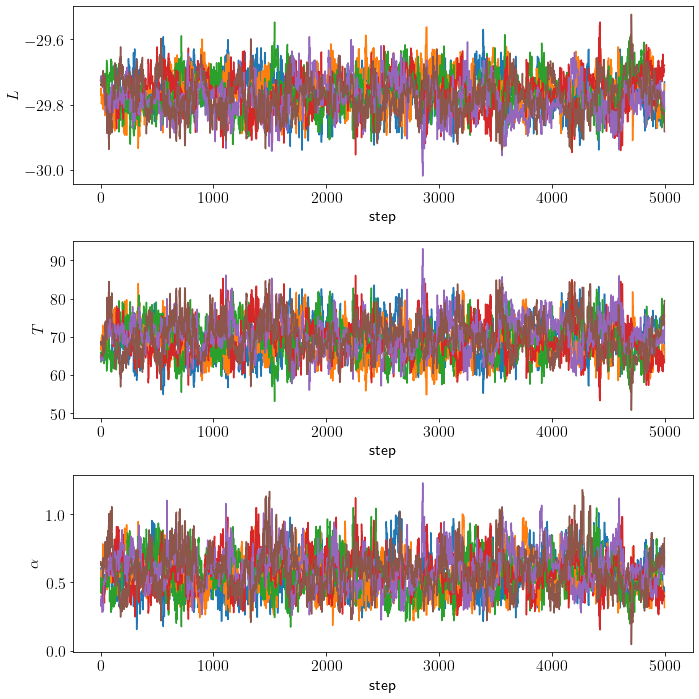

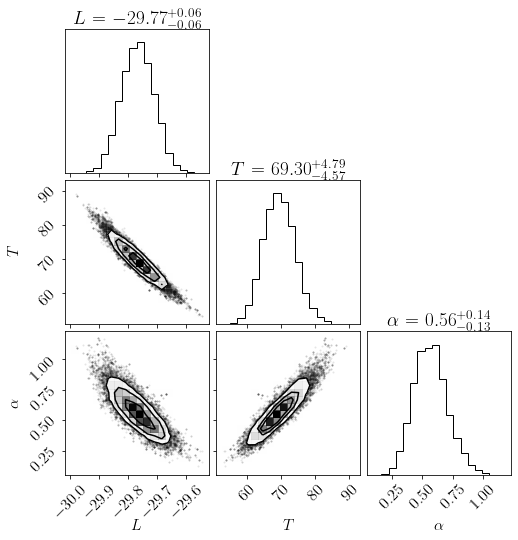

In [196]:
# Emcee run for Arp 220 model

ndim = 3
nwalk = ndim*2
nburn = 2000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit_sub3 + np.random.uniform(low=-0.05, high=0.05, size=3)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob2, args=(frequencies_APM, flux_densities_APM, errors_APM))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$'))
f.show()